# 【第２回目　課題２】Kerasを使った深層学習 (2): 畳み込み編

課題１に引き続いてKerasのSequential modelを用いて，前回の課題２のフィルタ学習を行ってみます．
エッジ検出のフィルタを3層の畳み込みネットワークで学習してみます．

入出力は画像ですが，基本的に出力回帰問題ですので，課題１と同じで，最小２乗誤差を用いて学習します．

In [1]:
import numpy as np
import math
import time

import keras
from keras.models import Sequential
from keras.layers import Conv2D, BatchNormalization

Using TensorFlow backend.
using GPU: 1


次に画像の読み込みに必要なPIL, 表示に必要なmatplotlibなどのモジュールを読み込みます．

In [2]:
from skimage import feature,filters
from PIL import Image
import os
import sys

%matplotlib inline
import matplotlib.pyplot as plt
from IPython import display
import keras

画像を読み込んで，エッジ画像を生成して，学習データを作ります．

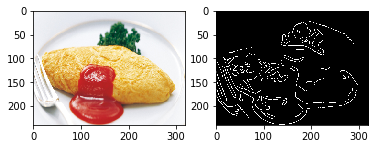

In [3]:
img_org = Image.open('uec.jpg').resize((320,240))
img = np.array(img_org, dtype=np.uint8)
grey = np.array(img_org.convert('L'), dtype=np.uint8)
edge = feature.canny(grey,sigma=2)  # Canny でエッジ抽出
# edge = filters.sobel(grey) # Sobel でエッジ抽出
edge = edge * 255

# エッジ検出フィルタ，グレースケール化フィルタの切り替え
use_edge=True  # Falseだとグレースケール化フィルタの学習
if use_edge:
  gt=edge
else:
  gt=grey

plt.subplot(121)
plt.imshow(img)
plt.subplot(122)
plt.imshow(gt,cmap="gray")

読み込んだ画像と変換した画像を，numpy形式に変換します．
(h,w,c) h:高さ, w:幅, c:チャネル　のサイズの3次元配列にします．
なお，前回は，(c,h,w) でしたが，Kerasの標準の形式は，(h,w,c) ですので
注意してください．

ここでは画像は320x240で，入力はカラーなので，
input: (240,320,3)
output: (240,320,1)
の大きさです．

In [4]:
# 画素値が [-1,1) の範囲の値になるように変換
# Keras は (h,w,c)が標準ですので，前回の
#input  = (np.asarray(img, dtype=np.float32).transpose(2,0,1)-128)/128.0 の transposeが不要になります．
input  = (np.asarray(img, dtype=np.float32)-127.5)/127.5
output = (np.asarray(gt, dtype=np.float32)-127.5)/127.5

# Keras では，convolution へ与えるデータは最初にbatchの次元を追加して４次元テンソルで表現します．
# 画像１枚での学習なので，batch は 1 です．
input = input[np.newaxis, ...]               # (240,320,3) -> (1,240,320,3)
output = output[np.newaxis, ..., np.newaxis] # (230,320) -> (1,240,320,1)

In [5]:
# callback のクラス ShowGraphを定義
# グラフ表示で必要なので，コンストラクタで，model, 最大エポック数 を受け取っておく．
# model は，学習途中のパラメータを用いて， y=f(x)を描画するのに必要．
class ShowGraph(keras.callbacks.Callback):
    def __init__(self,model,max_epoch,test_img):
        # 表示エリアの設定
        self.fig=plt.figure()
        self.fig1 = self.fig.add_subplot(121)
        self.fig1.axis([0, max_epoch, 0, 1])
        self.fig1.set_title('loss')
        self.fig1.set_ylabel('loss')
        self.fig1.set_xlabel('epoch')
        self.fig2 = self.fig.add_subplot(122)
        self.fig2.axis([-8,8,-10,30])
        self.model=model
        self.max_epoch=max_epoch
        self.test_img=test_img
        self.start=time.time()
    
    # 学習の最初に呼び出される
    def on_train_begin(self, logs={}):
        self.losses=[]
        self.n_epoch=[]
    
    # 各epochの最後に呼び出される
    def on_epoch_end(self, epoch, logs={}):
        self.n_epoch.append(epoch)
        self.losses.append(logs.get('loss'))
        self.loss=logs.get('loss')
    
        display.clear_output(wait = True)
        self.fig1.plot(self.n_epoch,self.losses,"r") 
        out=self.model.predict_on_batch(self.test_img)
        self.out=(out.squeeze()+1.0)*127.5  # 表示するときは，[0.255]に戻します．
        #print out.shape, self.out.shape
        self.fig2.imshow(self.out,cmap="gray",vmin=0,vmax=255)
        display.display(self.fig)
        if epoch<self.max_epoch-1:
            self.fig2.cla()

    # デストラクタ(オブジェクトが消滅時に実行される)  
    # グラフが２つ表示されるのを防止．さらに最終val loss値の表示．
    def __del__(self):
        display.clear_output(wait = True)
        print("loss:",self.loss)
        print('Time: ',time.time()-self.start)


畳み込み層を3つ用意します．
3x3x10 -> 3x3x10 -> 3x3x1 です．
1,2層目はReLU付きです．

<a href="https://keras.io/ja/layers/convolutional/#conv2d">Conv2D</a>を利用します．

最初の Conv2Dでは画像入力サイズを指定する必要がありますが，(None,None,3) とすることで，channel数だけを指定して，入力画像サイズは可変とします．
Kerasでは，paddingは値を指定するのではなく，padding あり/なし のどちらかです．padding="same" と指定すると，feature mapのサイズが変化しないように padding の値が自動的にセットされます．

なお，Kerasでのパラメータ初期値の設定方法は，<a href="https://keras.io/ja/initializers/#glorot_uniform">kernel_initializer='glorot_uniform'</a> となっています．Heの初期値がいい場合は，<a href="https://keras.io/ja/initializers/#he_normal">kernel_initializer='he_normal'</a>と指定する必要があります．ここでは，he_normalを指定してみます．

In [6]:
#c1=Conv(3,3,3,10,pad=1)
#c2=Conv(10,3,3,10,pad=1)
#c3=Conv(10,3,3,1,pad=1,relu=0)

model = Sequential()
model.add(Conv2D(10, 3, padding='same', activation='relu', input_shape=(None, None, 3), kernel_initializer='he_normal'))
#model.add(BatchNormalization())
model.add(Conv2D(10, 3, padding='same', activation='relu', kernel_initializer='he_normal'))
#model.add(BatchNormalization())
model.add(Conv2D(1, 3, padding='same', kernel_initializer='he_normal'))
#model.add(Conv2D(1, 3, padding='same', activation='tanh', kernel_initializer='he_normal'))

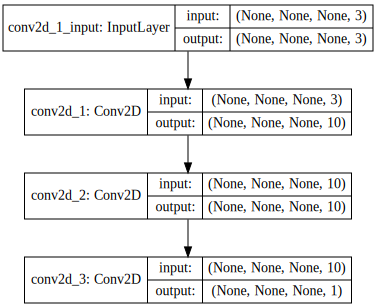

In [7]:
# model の表示
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
SVG(model_to_dot(model, show_shapes=True, show_layer_names=True).create(prog='dot', format='svg'))

学習ループです．
学習率lr = 0.01
エポック数200とします．


In [8]:
num_epoch=200

sdg = keras.optimizers.SGD(lr=0.01, momentum=0.0, decay=0.0)

sdg_momentum = keras.optimizers.SGD(lr=0.01, momentum=0.9, decay=0)  # momentam ありの場合．
rmsprop = keras.optimizers.RMSprop()
adam = keras.optimizers.Adam()

model.compile(optimizer=rmsprop, loss='mean_squared_error')

('loss:', 0.15261510014533997)
('Time: ', 41.12885093688965)


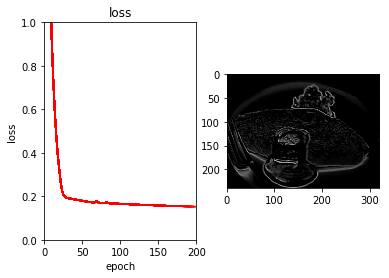

In [9]:
show_graph=ShowGraph(model,num_epoch,input)
model.fit(input, output, batch_size=1, epochs=num_epoch, verbose=0, callbacks=[show_graph])
del show_graph

### 課題2
サンプル画像を各自，自分で用意した画像に入れ替えて，以下の小問の(1)-(3)を解答すること．

1. OptimizerをモーメンタムSDG, RMSprop, Adamに変更して，ノーマルなSDGとの違いを観察せよ．
1. (1)で最もlossが小さくなったoptimizerを利用して，Batch Normalization Layer を入れた場合と入れない場合で，結果を比較せよ．

### 感想
RMSpropがもっともよい結果を出した。Adamのロスが一番低いかと思ったので少し意外な結果だった。